# [PanNuke Semantic Segmentation](https://huggingface.co/datasets/RationAI/PanNuke)

PanNuke is a semi-automatically generated dataset for **nuclei instance segmentation and classification**, providing comprehensive nuclei annotations across 19 tissue types and **5 distinct cell categories**. The dataset includes a total of 189,744 labeled nuclei, each accompanied by an instance segmentation mask, and contains 7,901 images, each sized 256×256 pixels. The images were captured at x40 magnification with a resolution of 0.25 µm/pixel. The dataset is highly imbalanced, with the "Dead" nuclei category being particularly underrepresented.

Guides followed:
* [Kaggle: Semantic Segmentation is Easy with PyTorch](https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch)
* [U-Net: Training Image Segmentation Models in PyTorch](https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/)

U-Net architecture taken from: [LabML.ai](https://nn.labml.ai/unet/index.html) as the implementation of the U-Net model from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

<div style="text-align: center;">
    <img src="https://nn.labml.ai/unet/unet.png" alt="Vanilla U-Net architecture" style="width: 50%;"/>
</div>

### Dataset's structure
It is organized in three separate folds: `fold1`, `fold2` and `fold3`. Each folder includes data in tabular format with the following columns:
* `image`: RGB PIL image of the sample
* `instances`: List of nuclei instances. Each instance represents exactly one nucleus and is in binary format (1: nucleus, 0: background)
* `categories`: An integer class label for each nucleus, corresponding to one of the following categories:
 0. Neoplastic
 1. Inflammatory
 2. Connective
 3. Dead
 4. Epithelial
* `tissue`: The integer tissue type from which the sample originates, belonging to one of these categories:
 0. Adrenal Gland
 1. Bile Duct
 2. Bladder
 3. Breast
 4. Cervix
 5. Colon
 6. Esophagus
 7. Head & Neck
 8. Kidney
 9. Liver
 10. Lung
 11. Ovarian
 12. Pancreatic
 13. Prostate
 14. Skin
 15. Stomach
 16. Testis
 17. Thyroid
 18. Uterus

## Import packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T2
#import torchvision.transforms as T
import torchvision
#import torchvision.transforms.functional
#from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from PIL import Image
#import cv2

import time
#import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Downloading dataset from Hugging Face website

In [2]:
from datasets import load_dataset, concatenate_datasets

ds = load_dataset("RationAI/PanNuke")

In [3]:
print(ds)

DatasetDict({
    fold1: Dataset({
        features: ['image', 'instances', 'categories', 'tissue'],
        num_rows: 2656
    })
    fold2: Dataset({
        features: ['image', 'instances', 'categories', 'tissue'],
        num_rows: 2523
    })
    fold3: Dataset({
        features: ['image', 'instances', 'categories', 'tissue'],
        num_rows: 2722
    })
})


In [4]:
print(ds['fold1'])

Dataset({
    features: ['image', 'instances', 'categories', 'tissue'],
    num_rows: 2656
})


## Dataset's structure display

In [5]:
print(f"Sample example:             {ds['fold1'][0]}")
print(f"Sample's keys:              {ds['fold1'][0].keys()}")
print(f"Sample's values:            {ds['fold1'][0].values()}")
print(f"Sample's image value:       {ds['fold1'][0]['image']}")
print(f"Sample's instance value:    {ds['fold1'][0]['instances']}")
print(f"Sample's category value:    {ds['fold1'][0]['categories']}")
print(f"Sample's tissue value:      {ds['fold1'][0]['tissue']}")

Sample example:             {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x75C8AC1DBFB0>, 'instances': [<PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C9DB6A0950>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C8AC1DB8C0>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72B6E0>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72B710>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72B740>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72B770>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72ABA0>, <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256 at 0x75C88E72B530>], 'categories': [0, 0, 0, 0, 1, 1, 2, 2], 'tissue': 3}
Sample's keys:              dict_keys(['image', 'instances', 'categories', 'tissue'])
Sample's values:            dict_values([<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2

## Concatenate folds into a single dataset variable

In [6]:
train_ds = concatenate_datasets([ds['fold1'], ds['fold2']])
train_ds = train_ds.shuffle(seed=42)

test_ds = ds['fold3']
test_ds = test_ds.shuffle(seed=42)

In [7]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'instances', 'categories', 'tissue'],
    num_rows: 5179
})
Dataset({
    features: ['image', 'instances', 'categories', 'tissue'],
    num_rows: 2722
})


In [8]:
test_ds = test_ds.train_test_split(test_size=0.5, seed=42) # test_ds['train'] for the validation
print(test_ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'instances', 'categories', 'tissue'],
        num_rows: 1361
    })
    test: Dataset({
        features: ['image', 'instances', 'categories', 'tissue'],
        num_rows: 1361
    })
})


## Displaying an image with it's mask

Image Size (256, 256, 3)
Mask Size (256, 256)


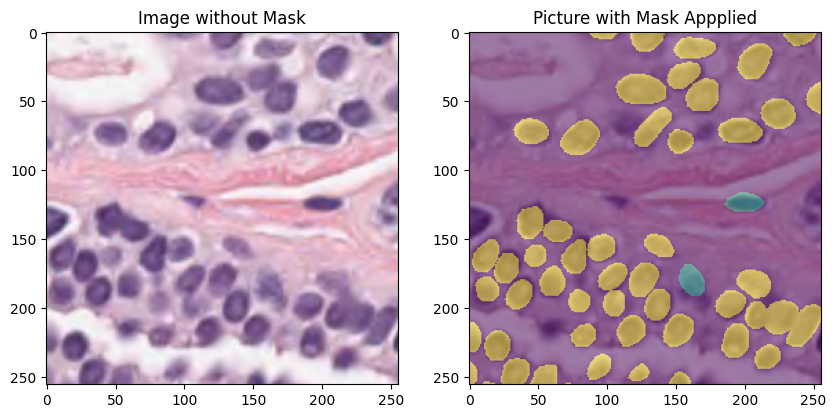

In [9]:
img = np.array(train_ds[4]['image'])
img = Image.fromarray(img)

mask = np.zeros((256, 256), dtype=np.uint8)
for inst, categ in zip(train_ds[4]['instances'], train_ds[4]['categories']):
    inst_np = np.array(inst, dtype=np.uint8)
    mask[inst_np == 1] = categ + 1

mask = Image.fromarray(mask)

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image without Mask')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

## Finding imbalance to create class weights

In [10]:
"""
 0. Neoplastic
 1. Inflammatory
 2. Connective
 3. Dead
 4. Epithelial
"""

neoplastic = 0
inflammatory = 0
connective = 0
dead = 0
epithelial = 0

for i in range(len(train_ds)):
    for value in train_ds[i]['categories']:
        if value == 0:
            neoplastic += 1
        elif value == 1:
            inflammatory += 1
        elif value == 2:
            connective += 1
        elif value == 3:
            dead += 1
        elif value == 4:
            epithelial += 1

print(f"In the training set, there are: \n{neoplastic} Neoplastic samples")
print(f"{inflammatory} Inflammatory samples")
print(f"{connective} Connective samples")
print(f"{dead} Dead samples")
print(f"{epithelial} Epithelial samples")

In the training set, there are: 
48932 Neoplastic samples
21451 Inflammatory samples
33144 Connective samples
1851 Dead samples
17712 Epithelial samples


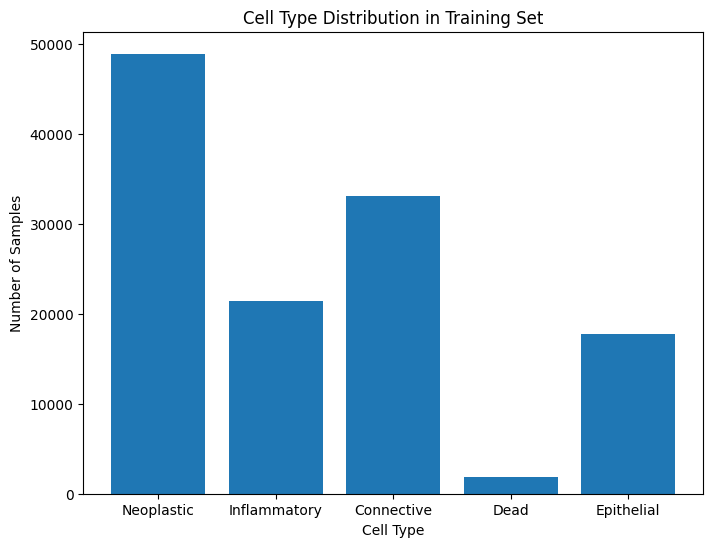

In [11]:
cell_values = np.array([neoplastic, inflammatory, connective, dead, epithelial])
plt.figure(figsize=(8, 6))
plt.bar(['Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial'], cell_values)
plt.title('Cell Type Distribution in Training Set')
plt.xlabel('Cell Type')
plt.ylabel('Number of Samples')
plt.xticks(size=10)
plt.show()

## As mentioned in the beginning, dead cells are underepresented in the dataset. To deal with this imbalance, we will define class weights.

In [12]:
def class_weights(list, n_classes=5):
    total = sum(list)
    weights = [1.0]
    for i in range(len(list)):
        weights.append(1+total/(list[i]*n_classes))
    return weights

weights = torch.tensor(class_weights(cell_values), dtype=torch.float32).to(device)
print(f"Class Weights: {weights}")

Class Weights: tensor([ 1.0000,  1.5031,  2.1476,  1.7428, 14.2998,  2.3899], device='cuda:0')


## Let's create a custom dataset class which will convert data values into proper formats
The class will receive the dataset dictionary variable, the fold we work with and transformations applied for augmentation cases.

## Inserting constants

In [13]:
NUM_CLASSES = 6 # 0: background, 1: Neoplastic, 2: Inflammatory, 3: Connective, 4: Dead, 5: Epithelial
CHANNELS = 3
BATCH_SIZE = 4
mean = [0.485, 0.456, 0.406] # mean of ImageNet
std = [0.229, 0.224, 0.225] # std of ImageNet

### Images and Instances (or masks) are in PIL format. In order to load the images on a DataLoader, we have to convert them into NumPy arrays firstly, or into Tesnors directly if it is possible.

In [14]:
class PanNukeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Args:
            dataset: PanNuke loaded from Hugging Face.
            transform: torchvision transforms for image and mask.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load sample
        sample = self.dataset[idx]
        image = sample['image']
        instances = sample['instances']  # list of binary masks
        categories = sample['categories']  # list of nucleus category (0–4)

        # converting image to tensor
        image = T2.ToTensor()(image)  # shape: (3, 256, 256)

        # creating segmentation mask
        seg_mask = np.zeros((256, 256), dtype=np.uint8)
        for inst, categ in zip(instances, categories):
            # binary mask to numpy (0 or 1)
            inst_np = np.array(inst, dtype=np.uint8)
            # Assign category: 0. Neoplastic, 1. Inflammatory, 2. Connective, 3. Dead, 4. Epithelial.
            seg_mask[inst_np == 1] = categ + 1 # 0 values are background while 1-5 will be the corresponding nucleus categories in the mask


        # converting mask to tensor
        seg_mask = torch.from_numpy(seg_mask).long()  # Shape: (256, 256)

        # Apply transforms (if any)
        if self.transform:
            image = self.transform(image)

        return image, seg_mask

## Transformations

In [15]:
train_transform = T2.Compose([
    T2.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    T2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T2.Normalize(mean=mean, std=std)
    ])

val_transform = T2.Compose([
    T2.Normalize(mean=mean, std=std)
])

## Let's load the data

In [16]:
train_dataset = PanNukeDataset(train_ds, transform=train_transform)

val_dataset = PanNukeDataset(test_ds['train'], transform=val_transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 5179
Validation dataset size: 1361


In [17]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

In [18]:
train_image, train_mask = next(iter(train_loader))
print(f"Train image shape: {train_image.shape}")
print(f"Train mask shape: {train_mask.shape}")

Train image shape: torch.Size([4, 3, 256, 256])
Train mask shape: torch.Size([4, 256, 256])


/home/tsopermon/venv/ds/projects/deep_learning_aivc_project/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Model Initialization

In [19]:
model = smp.Unet(
    encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or resnet50
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=CHANNELS,  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,  # model output channels (number of classes in your dataset)
    activation=None,  # activation function (if None, logits are returned)
)
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [20]:
train_steps = len(train_dataset) // BATCH_SIZE
val_steps = len(val_dataset) // BATCH_SIZE

print(f"Train steps: {train_steps}, Validation steps: {val_steps}")

Train steps: 1294, Validation steps: 340


## Training

In [21]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [22]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = nn.functional.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1) #flatten pred_mask
        mask = mask.contiguous().view(-1) #flatten the mask

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [23]:
def seg_dice(pred_mask, mask, smooth=1e-10, n_classes=6):
    """
    Dice score is another name for F1 score which can be calculated by dividing the multiplied 
    intersection of the predicted and true masks by the sum of the predicted and true masks.
    But we can calculate it using TP, FP and FN as well.

    But we will follow the original definition of Dice score:
    Dice = 2 * |X ∩ Y| / (|X| + |Y| + smooth)

    where |X| is the predicted mask and |Y| is the true mask.
    
    Proof: https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics, https://lathashreeh.medium.com/dice-coefficient-what-is-it-ff090ec97bda
    """
    with torch.no_grad():
        pred_mask = nn.functional.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1) #flatten pred_mask
        mask = mask.contiguous().view(-1) #flatten the mask

        dice_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                instersect = torch.logical_and(true_class, true_label).sum().float().item() # intersection of the predicted and true masks
                pred_sum = true_class.sum().float().item() # the number of pixels in the predicted mask
                true_sum = true_label.sum().float().item() # the number of pixels in the true mask
                dice = (2 * instersect + smooth) / (pred_sum + true_sum + smooth)

                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)

In [24]:
def seg_precision(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = nn.functional.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1) #flatten pred_mask
        mask = mask.contiguous().view(-1) #flatten the mask

        precision_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                precision_per_class.append(np.nan)
            else:
                true_positive = torch.logical_and(true_class, true_label).sum().float().item()
                false_positive = torch.logical_and(true_class, torch.logical_not(true_label)).sum().float().item()

                precision = (true_positive + smooth) / (true_positive + false_positive + smooth)
                precision_per_class.append(precision)
        return np.nanmean(precision_per_class)

In [25]:
def seg_recall(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = nn.functional.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1) #flatten pred_mask
        mask = mask.contiguous().view(-1) #flatten the mask

        recall_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                recall_per_class.append(np.nan)
            else:
                true_positive = torch.logical_and(true_class, true_label).sum().float().item()
                false_negative = torch.logical_and(torch.logical_not(true_class), true_label).sum().float().item()

                recall = (true_positive + smooth) / (true_positive + false_negative + smooth)
                recall_per_class.append(recall)
        return np.nanmean(recall_per_class)

In [26]:
def get_lr(optimizer):
    """
    get the current learning rate from the optimizer.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [27]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []; val_prec = []; val_rec = []; val_dice = []
    train_iou = []; train_acc = []; train_prec = []; train_rec = []; train_dice = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        precision = 0
        recall = 0
        dice = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            precision += seg_precision(output, mask)
            recall += seg_recall(output, mask)
            dice += seg_dice(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            val_prec_score = 0
            val_rec_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    val_prec_score += seg_precision(output, mask)
                    val_rec_score += seg_recall(output, mask)
                    val_dice_score += seg_dice(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Res50-UNet-mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 12:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            #accuracy
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            #precision
            train_prec.append(precision/len(train_loader))
            val_prec.append(val_prec_score/len(val_loader))
            #recall
            train_rec.append(recall/len(train_loader))
            val_rec.append(val_rec_score/len(val_loader))
            #dice
            train_dice.append(dice/len(train_loader))
            val_dice.append(val_dice_score/len(val_loader))

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Train Precision:{:.3f}..".format(precision/len(train_loader)),
                  "Val Precision:{:.3f}..".format(val_prec_score/len(val_loader)),
                  "Train Recall:{:.3f}..".format(recall/len(train_loader)),
                  "Val Recall:{:.3f}..".format(val_rec_score/len(val_loader)),
                  "Train Dice:{:.3f}..".format(dice/len(train_loader)),
                  "Val Dice:{:.3f}..".format(val_dice_score/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'train_prec' :train_prec, 'val_prec':val_prec,
               'train_rec' :train_rec, 'val_rec':val_rec,
               'train_dice' :train_dice, 'val_dice':val_dice,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Loss function and Optimizer
We will use Cross entropy loss as a loss function because we have a multi-class segmentation task.

In [28]:
MAX_LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 100

criterion = CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS,
                                            steps_per_epoch=len(train_loader))

In [29]:
history = fit(EPOCHS, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.506 
Epoch:1/100.. Train Loss: 0.960.. Val Loss: 0.506.. Train mIoU:0.307.. Val mIoU: 0.424.. Train Acc:0.766.. Val Acc:0.892.. Train Precision:0.445.. Val Precision:0.577.. Train Recall:0.423.. Val Recall:0.540.. Train Dice:0.384.. Val Dice:0.515.. Time: 1.35m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.506 >> 0.388 
Epoch:2/100.. Train Loss: 0.493.. Val Loss: 0.388.. Train mIoU:0.428.. Val mIoU: 0.500.. Train Acc:0.886.. Val Acc:0.909.. Train Precision:0.588.. Val Precision:0.650.. Train Recall:0.566.. Val Recall:0.626.. Train Dice:0.534.. Val Dice:0.610.. Time: 1.32m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.388 >> 0.379 
Epoch:3/100.. Train Loss: 0.429.. Val Loss: 0.379.. Train mIoU:0.475.. Val mIoU: 0.500.. Train Acc:0.897.. Val Acc:0.901.. Train Precision:0.627.. Val Precision:0.648.. Train Recall:0.635.. Val Recall:0.646.. Train Dice:0.589.. Val Dice:0.610.. Time: 1.29m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.379 >> 0.360 
saving model...
Epoch:4/100.. Train Loss: 0.394.. Val Loss: 0.360.. Train mIoU:0.495.. Val mIoU: 0.516.. Train Acc:0.903.. Val Acc:0.913.. Train Precision:0.642.. Val Precision:0.680.. Train Recall:0.660.. Val Recall:0.649.. Train Dice:0.610.. Val Dice:0.628.. Time: 1.32m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/100.. Train Loss: 0.375.. Val Loss: 0.362.. Train mIoU:0.505.. Val mIoU: 0.503.. Train Acc:0.905.. Val Acc:0.901.. Train Precision:0.650.. Val Precision:0.644.. Train Recall:0.668.. Val Recall:0.653.. Train Dice:0.619.. Val Dice:0.616.. Time: 1.31m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.362 >> 0.354 
Epoch:6/100.. Train Loss: 0.366.. Val Loss: 0.354.. Train mIoU:0.510.. Val mIoU: 0.510.. Train Acc:0.908.. Val Acc:0.900.. Train Precision:0.652.. Val Precision:0.637.. Train Recall:0.673.. Val Recall:0.670.. Train Dice:0.625.. Val Dice:0.624.. Time: 1.29m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.347 
Epoch:7/100.. Train Loss: 0.366.. Val Loss: 0.347.. Train mIoU:0.506.. Val mIoU: 0.516.. Train Acc:0.906.. Val Acc:0.911.. Train Precision:0.645.. Val Precision:0.669.. Train Recall:0.665.. Val Recall:0.646.. Train Dice:0.621.. Val Dice:0.628.. Time: 1.31m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/100.. Train Loss: 0.369.. Val Loss: 0.350.. Train mIoU:0.501.. Val mIoU: 0.515.. Train Acc:0.906.. Val Acc:0.902.. Train Precision:0.641.. Val Precision:0.620.. Train Recall:0.659.. Val Recall:0.701.. Train Dice:0.615.. Val Dice:0.629.. Time: 1.33m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:9/100.. Train Loss: 0.362.. Val Loss: 0.396.. Train mIoU:0.505.. Val mIoU: 0.490.. Train Acc:0.906.. Val Acc:0.884.. Train Precision:0.645.. Val Precision:0.608.. Train Recall:0.663.. Val Recall:0.674.. Train Dice:0.620.. Val Dice:0.609.. Time: 1.35m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.396 >> 0.395 
Epoch:10/100.. Train Loss: 0.364.. Val Loss: 0.395.. Train mIoU:0.504.. Val mIoU: 0.489.. Train Acc:0.906.. Val Acc:0.893.. Train Precision:0.647.. Val Precision:0.632.. Train Recall:0.660.. Val Recall:0.651.. Train Dice:0.619.. Val Dice:0.601.. Time: 1.32m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:11/100.. Train Loss: 0.373.. Val Loss: 0.406.. Train mIoU:0.493.. Val mIoU: 0.475.. Train Acc:0.904.. Val Acc:0.882.. Train Precision:0.637.. Val Precision:0.599.. Train Recall:0.651.. Val Recall:0.650.. Train Dice:0.607.. Val Dice:0.588.. Time: 1.31m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.406 >> 0.381 
Epoch:12/100.. Train Loss: 0.374.. Val Loss: 0.381.. Train mIoU:0.494.. Val mIoU: 0.499.. Train Acc:0.904.. Val Acc:0.900.. Train Precision:0.640.. Val Precision:0.617.. Train Recall:0.649.. Val Recall:0.661.. Train Dice:0.607.. Val Dice:0.612.. Time: 1.32m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.381 >> 0.381 
saving model...
Epoch:13/100.. Train Loss: 0.382.. Val Loss: 0.381.. Train mIoU:0.488.. Val mIoU: 0.482.. Train Acc:0.902.. Val Acc:0.893.. Train Precision:0.636.. Val Precision:0.648.. Train Recall:0.643.. Val Recall:0.617.. Train Dice:0.602.. Val Dice:0.591.. Time: 1.35m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:14/100.. Train Loss: 0.381.. Val Loss: 0.384.. Train mIoU:0.487.. Val mIoU: 0.486.. Train Acc:0.902.. Val Acc:0.900.. Train Precision:0.635.. Val Precision:0.642.. Train Recall:0.639.. Val Recall:0.625.. Train Dice:0.599.. Val Dice:0.595.. Time: 1.39m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:15/100.. Train Loss: 0.378.. Val Loss: 0.422.. Train mIoU:0.492.. Val mIoU: 0.468.. Train Acc:0.903.. Val Acc:0.886.. Train Precision:0.645.. Val Precision:0.653.. Train Recall:0.647.. Val Recall:0.592.. Train Dice:0.606.. Val Dice:0.580.. Time: 1.42m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.422 >> 0.386 
Epoch:16/100.. Train Loss: 0.381.. Val Loss: 0.386.. Train mIoU:0.488.. Val mIoU: 0.490.. Train Acc:0.902.. Val Acc:0.898.. Train Precision:0.635.. Val Precision:0.637.. Train Recall:0.644.. Val Recall:0.635.. Train Dice:0.602.. Val Dice:0.602.. Time: 1.36m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:17/100.. Train Loss: 0.381.. Val Loss: 0.387.. Train mIoU:0.486.. Val mIoU: 0.472.. Train Acc:0.902.. Val Acc:0.897.. Train Precision:0.633.. Val Precision:0.646.. Train Recall:0.642.. Val Recall:0.612.. Train Dice:0.599.. Val Dice:0.580.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.387 >> 0.354 
Epoch:18/100.. Train Loss: 0.380.. Val Loss: 0.354.. Train mIoU:0.490.. Val mIoU: 0.512.. Train Acc:0.902.. Val Acc:0.909.. Train Precision:0.634.. Val Precision:0.667.. Train Recall:0.646.. Val Recall:0.643.. Train Dice:0.604.. Val Dice:0.623.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:19/100.. Train Loss: 0.381.. Val Loss: 0.371.. Train mIoU:0.488.. Val mIoU: 0.495.. Train Acc:0.902.. Val Acc:0.900.. Train Precision:0.635.. Val Precision:0.627.. Train Recall:0.643.. Val Recall:0.665.. Train Dice:0.601.. Val Dice:0.606.. Time: 1.33m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.371 >> 0.362 
Epoch:20/100.. Train Loss: 0.386.. Val Loss: 0.362.. Train mIoU:0.484.. Val mIoU: 0.508.. Train Acc:0.901.. Val Acc:0.909.. Train Precision:0.636.. Val Precision:0.655.. Train Recall:0.638.. Val Recall:0.645.. Train Dice:0.598.. Val Dice:0.619.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:21/100.. Train Loss: 0.382.. Val Loss: 0.408.. Train mIoU:0.488.. Val mIoU: 0.480.. Train Acc:0.902.. Val Acc:0.892.. Train Precision:0.637.. Val Precision:0.645.. Train Recall:0.642.. Val Recall:0.613.. Train Dice:0.601.. Val Dice:0.588.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.408 >> 0.377 
Epoch:22/100.. Train Loss: 0.381.. Val Loss: 0.377.. Train mIoU:0.485.. Val mIoU: 0.491.. Train Acc:0.901.. Val Acc:0.900.. Train Precision:0.632.. Val Precision:0.632.. Train Recall:0.638.. Val Recall:0.655.. Train Dice:0.597.. Val Dice:0.600.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:23/100.. Train Loss: 0.375.. Val Loss: 0.391.. Train mIoU:0.491.. Val mIoU: 0.474.. Train Acc:0.903.. Val Acc:0.893.. Train Precision:0.639.. Val Precision:0.649.. Train Recall:0.643.. Val Recall:0.621.. Train Dice:0.605.. Val Dice:0.581.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.391 >> 0.375 
saving model...
Epoch:24/100.. Train Loss: 0.374.. Val Loss: 0.375.. Train mIoU:0.491.. Val mIoU: 0.479.. Train Acc:0.903.. Val Acc:0.904.. Train Precision:0.638.. Val Precision:0.680.. Train Recall:0.644.. Val Recall:0.594.. Train Dice:0.604.. Val Dice:0.587.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.375 >> 0.361 
Epoch:25/100.. Train Loss: 0.376.. Val Loss: 0.361.. Train mIoU:0.491.. Val mIoU: 0.506.. Train Acc:0.903.. Val Acc:0.904.. Train Precision:0.637.. Val Precision:0.645.. Train Recall:0.645.. Val Recall:0.658.. Train Dice:0.604.. Val Dice:0.618.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:26/100.. Train Loss: 0.375.. Val Loss: 0.400.. Train mIoU:0.488.. Val mIoU: 0.469.. Train Acc:0.903.. Val Acc:0.895.. Train Precision:0.639.. Val Precision:0.644.. Train Recall:0.641.. Val Recall:0.604.. Train Dice:0.601.. Val Dice:0.573.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.400 >> 0.396 
Epoch:27/100.. Train Loss: 0.368.. Val Loss: 0.396.. Train mIoU:0.498.. Val mIoU: 0.464.. Train Acc:0.905.. Val Acc:0.899.. Train Precision:0.646.. Val Precision:0.687.. Train Recall:0.651.. Val Recall:0.562.. Train Dice:0.612.. Val Dice:0.567.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Decreasing.. 0.396 >> 0.368 
Epoch:28/100.. Train Loss: 0.372.. Val Loss: 0.368.. Train mIoU:0.493.. Val mIoU: 0.497.. Train Acc:0.903.. Val Acc:0.900.. Train Precision:0.640.. Val Precision:0.635.. Train Recall:0.643.. Val Recall:0.657.. Train Dice:0.606.. Val Dice:0.607.. Time: 1.34m


  0%|          | 0/1295 [00:00<?, ?it/s]

  0%|          | 0/341 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Loss not decrease for 7 times, Stop Training
Total time: 38.73 m


In [30]:
torch.save(model, 'Res50_U-Net.pt')

In [31]:
model = torch.load('Res50_U-Net.pt', weights_only=False, map_location=device)

In [32]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_precision(history):
    plt.plot(history['train_prec'], label='train_precision', marker='*')
    plt.plot(history['val_prec'], label='val_precision',  marker='*')
    plt.title('Precision per epoch'); plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_recall(history):
    plt.plot(history['train_rec'], label='train_recall', marker='*')
    plt.plot(history['val_rec'], label='val_recall',  marker='*')
    plt.title('Recall per epoch'); plt.ylabel('Recall')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_dice(history):
    plt.plot(history['train_dice'], label='train_dice', marker='*')
    plt.plot(history['val_dice'], label='val_dice',  marker='*')
    plt.title('Dice per epoch'); plt.ylabel('Dice')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

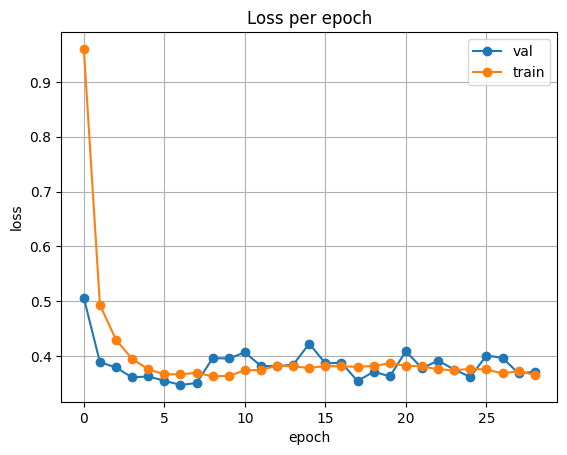

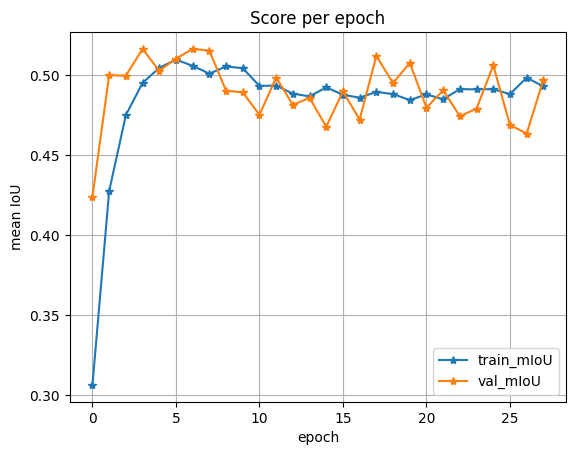

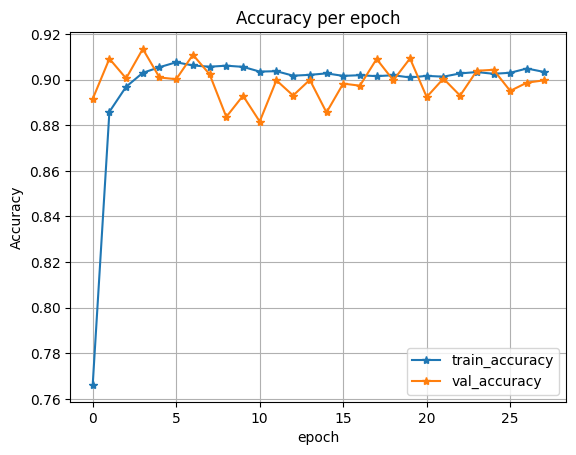

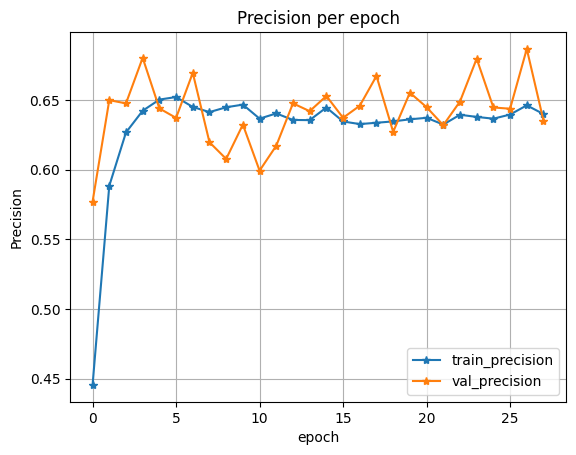

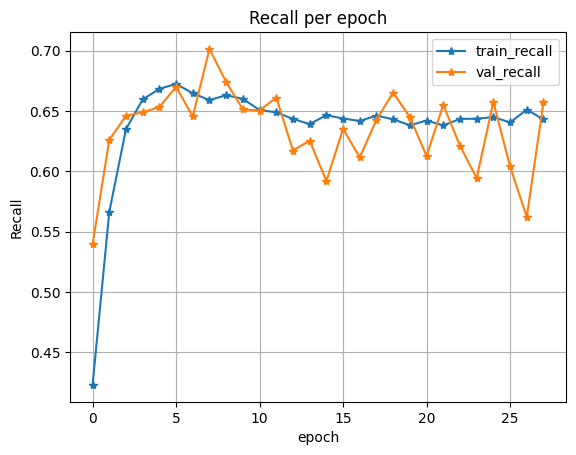

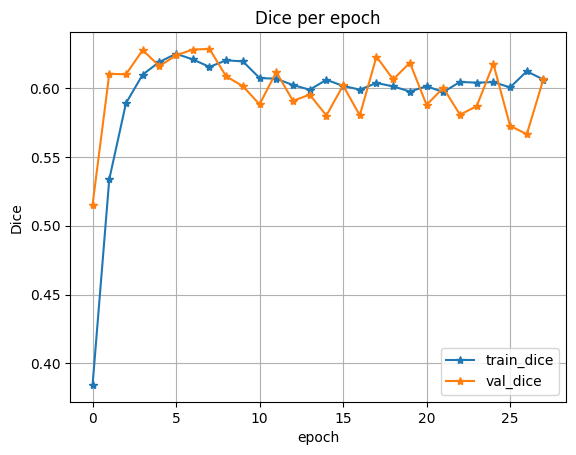

In [33]:
plot_loss(history)
plot_score(history)
plot_acc(history)
plot_precision(history)
plot_recall(history)
plot_dice(history)

## Evaluation

In [34]:
test_dataset = PanNukeDataset(test_ds['test'], transform=None)

In [35]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T2.Compose([T2.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [36]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T2.Compose([T2.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [37]:
def predict_image_mask_dice(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T2.Compose([T2.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        dice = seg_dice(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, dice

In [38]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [39]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [40]:
mob_miou = miou_score(model, test_dataset)

  0%|          | 0/1361 [00:00<?, ?it/s]

In [41]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [42]:
mob_acc = pixel_acc(model, test_dataset)

  0%|          | 0/1361 [00:00<?, ?it/s]

In [43]:
def dice_coeff(model, test_set):
    dice = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, d = predict_image_mask_dice(model, img, mask)
        dice.append(d)
    return dice

In [44]:
mob_dice = dice_coeff(model, test_dataset)

  0%|          | 0/1361 [00:00<?, ?it/s]

In [45]:
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

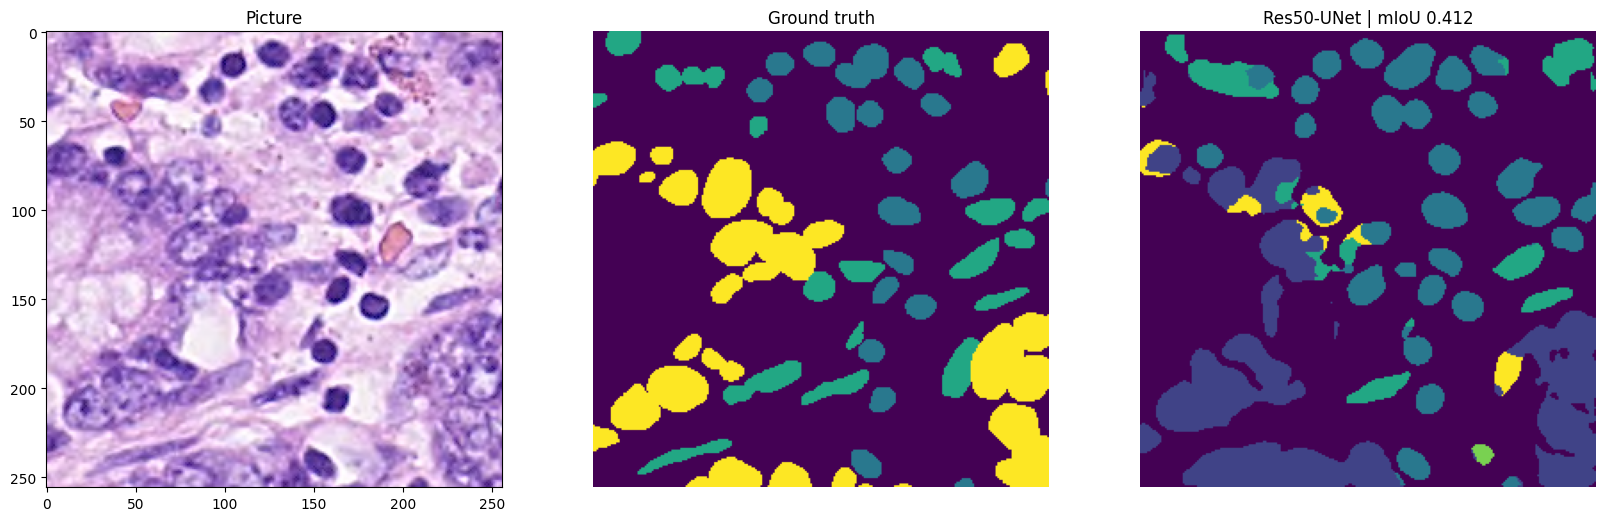

In [46]:
# https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch 
# used `.permute()` to put the image's channel as the last dimension

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image.permute(1, 2, 0))
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('Res50-UNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

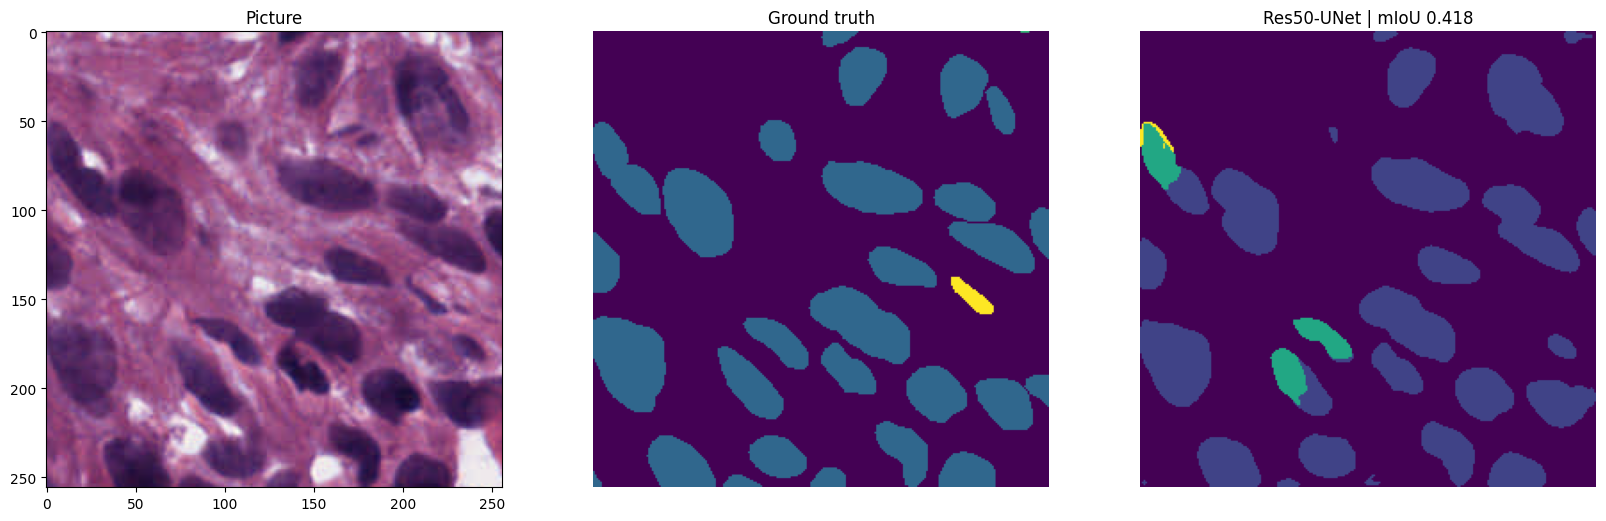

In [47]:
image2, mask2 = test_dataset[363]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2.permute(1, 2, 0))
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('Res50-UNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

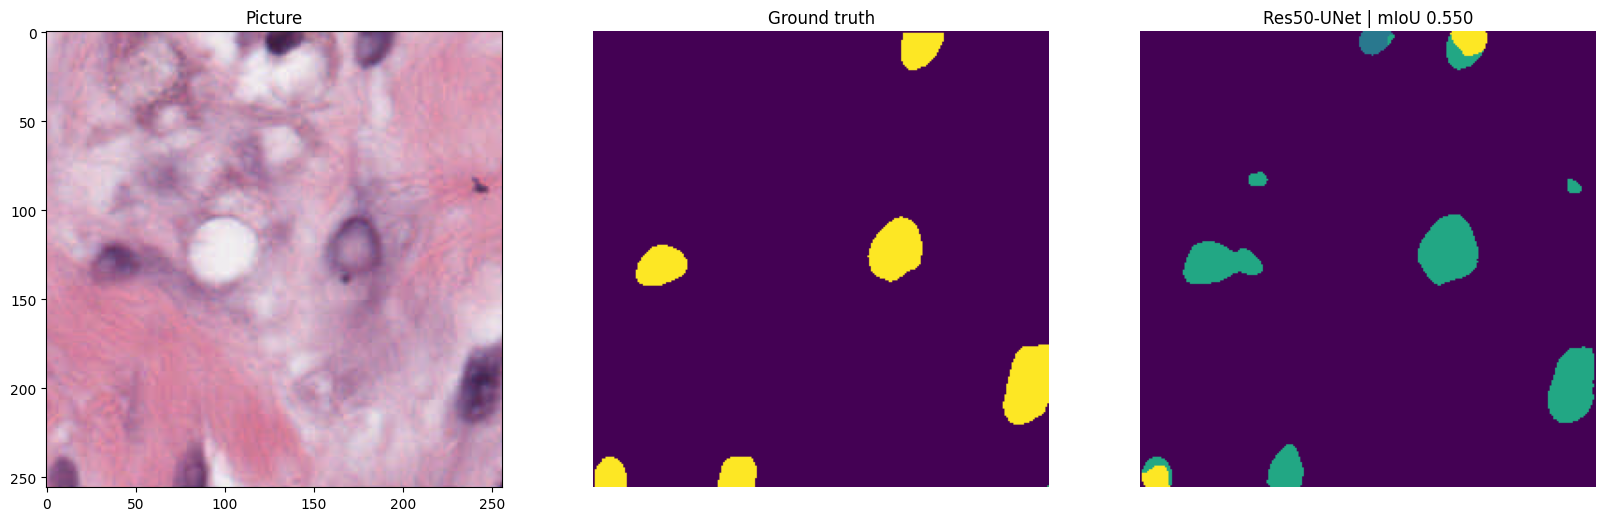

In [48]:
image3, mask3 = test_dataset[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3.permute(1, 2, 0))
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('Res50-UNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()


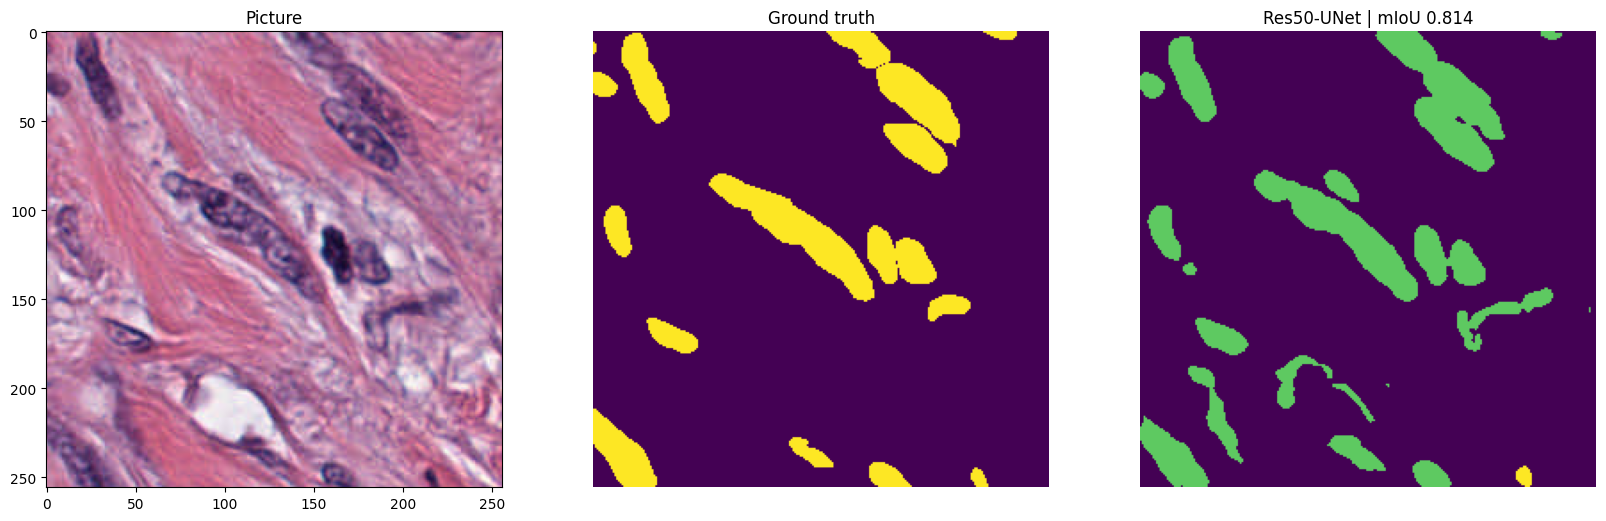

In [49]:
image3, mask3 = test_dataset[63]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3.permute(1, 2, 0))
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('Res50-UNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()


In [50]:
pred_mask.shape

torch.Size([256, 256])

In [51]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))
print('Test Set Dice Coefficient', np.mean(mob_dice))

Test Set mIoU 0.5742986709103088
Test Set Pixel Accuracy 0.902228563520332
Test Set Dice Coefficient 0.6551321177025814


In [52]:
torch.cuda.empty_cache()